<a href="https://colab.research.google.com/github/trewto/Rainfall-Trends-in-Bangladesh-Analysis/blob/main/Rainfall_Trend_GIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install cartopy

In [16]:

import pandas as pd


In [18]:

# Assuming the file is in /content/drive/MyDrive/research/
file_path = "/content/drive/MyDrive/research/with LongLat_rainfall_trend_results.csv"

try:
  df = pd.read_csv(file_path)
  print(df.head())  # Print the first few rows to verify
except FileNotFoundError:
  print(f"Error: File not found at {file_path}")
except Exception as e:
  print(f"An error occurred: {e}")


      Station  Station Number  Lat (Deg)  Lat (Min)  Long (Deg)  Long (Min)  \
0   chuadanga           41926         23         39          88          49   
1     Jessore           41936         23         12          89          20   
2      Khulna           41947         22         47          89          34   
3    Satkhira           41946         22         43          89           5   
4  Chittagong           41977         22         21          91          49   

   1    2    3        4  5  6    7    8    9   10   11  12  
0  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  
1  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  
2  0  0.0  0.0 -1.47619  0  0  0.0  0.0  0.0  0.0  0.0   0  
3  0  0.0  0.0 -2.22581  0  0  0.0  0.0  0.0  0.0  0.0   0  
4  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  


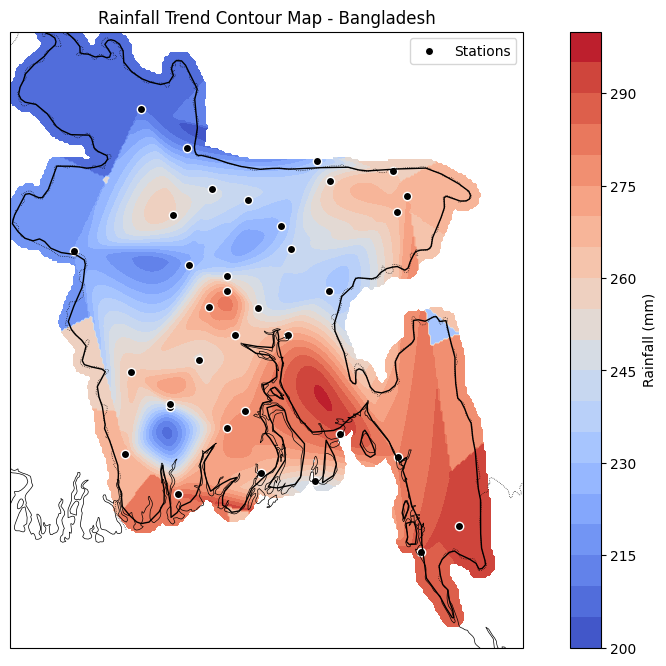

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from shapely.geometry import Point


# Load rainfall data into a DataFrame
from io import StringIO
data = pd.read_csv(StringIO(rainfall_data))

# Load Bangladesh boundary from Natural Earth (50m resolution)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
bangladesh_shp = world[world.NAME == "Bangladesh"]

# Create a polygon with a buffer for better edge coverage
bangladesh_polygon = bangladesh_shp.geometry.iloc[0].buffer(0.1)  # Small buffer of 0.1 degrees

# Define grid for interpolation
lon_min, lon_max = 88, 93   # Bangladesh Longitude range
lat_min, lat_max = 20.5, 26.5  # Bangladesh Latitude range
grid_x, grid_y = np.meshgrid(
    np.linspace(lon_min, lon_max, 300),  # Increased resolution
    np.linspace(lat_min, lat_max, 300)
)

# Interpolate using cubic method
grid_z_cubic = griddata((data["lon"], data["lat"]), data["rainfall"], (grid_x, grid_y), method='cubic')

# Fill gaps using nearest-neighbor method
grid_z_nearest = griddata((data["lon"], data["lat"]), data["rainfall"], (grid_x, grid_y), method='nearest')

# Combine cubic and nearest methods
grid_z = np.where(np.isnan(grid_z_cubic), grid_z_nearest, grid_z_cubic)

# Mask values outside Bangladesh
mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
grid_z[~mask.reshape(grid_z.shape)] = np.nan

# Plot the contour map
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max])

# Add Bangladesh border
ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

# Contour plot
contour = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap="coolwarm", transform=ccrs.PlateCarree())

# Add color bar
plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

# Add station points
ax.scatter(data["lon"], data["lat"], c='black', marker='o', edgecolors='white', label="Stations")

# Add features for better map context
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

# Labels
ax.set_title("Rainfall Trend Contour Map - Bangladesh")
ax.legend()

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from shapely.geometry import Point

# Assuming the file is in /content/drive/MyDrive/research/
file_path = "/content/drive/MyDrive/research/with LongLat_rainfall_trend_results.csv"

try:
    df = pd.read_csv(file_path)
    print(df.head())  # Print the first few rows to verify
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Convert Latitude and Longitude to Decimal Degrees for easy processing
df['lat_decimal'] = df['Lat (Deg)'] + df['Lat (Min)'] / 60
df['lon_decimal'] = df['Long (Deg)'] + df['Long (Min)'] / 60

# Load Bangladesh boundary from Natural Earth (50m resolution)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
bangladesh_shp = world[world.NAME == "Bangladesh"]

# Create a polygon with a buffer for better edge coverage
bangladesh_polygon = bangladesh_shp.geometry.iloc[0].buffer(0.1)  # Small buffer of 0.1 degrees

# Define grid for interpolation
lon_min, lon_max = 88, 93   # Bangladesh Longitude range
lat_min, lat_max = 20.5, 26.5  # Bangladesh Latitude range
grid_x, grid_y = np.meshgrid(
    np.linspace(lon_min, lon_max, 300),  # Increased resolution
    np.linspace(lat_min, lat_max, 300)
)

# Iterate over months (columns 6 to 17)
for month in range(1, 13):
    # Extract rainfall data for this month
    rainfall = df.iloc[:, 6 + month - 1]  # Column 6 corresponds to January, 7 to February, etc.

    # Interpolate using cubic method
    grid_z_cubic = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='cubic')

    # Fill gaps using nearest-neighbor method
    grid_z_nearest = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='nearest')

    # Combine cubic and nearest methods
    grid_z = np.where(np.isnan(grid_z_cubic), grid_z_nearest, grid_z_cubic)

    # Mask values outside Bangladesh
    mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z[~mask.reshape(grid_z.shape)] = np.nan

    # Plot the contour map for each month
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add Bangladesh border
    ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

    # Contour plot
    contour = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap="coolwarm", transform=ccrs.PlateCarree())

    # Add color bar
    plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

    # Add station points
    ax.scatter(df['lon_decimal'], df['lat_decimal'], c='black', marker='o', edgecolors='white', label="Stations")

    # Add features for better map context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

    # Labels
    ax.set_title(f"Rainfall Trend Contour Map - Bangladesh - {month} Month")
    ax.legend()

    # Save or show the figure
    plt.show()
    # Alternatively, you can save the figure with a specific filename
    # fig.savefig(f"rainfall_map_month_{month}.png")


      Station  Station Number  Lat (Deg)  Lat (Min)  Long (Deg)  Long (Min)  \
0   chuadanga           41926         23         39          88          49   
1     Jessore           41936         23         12          89          20   
2      Khulna           41947         22         47          89          34   
3    Satkhira           41946         22         43          89           5   
4  Chittagong           41977         22         21          91          49   

   1    2    3        4  5  6    7    8    9   10   11  12  
0  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  
1  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  
2  0  0.0  0.0 -1.47619  0  0  0.0  0.0  0.0  0.0  0.0   0  
3  0  0.0  0.0 -2.22581  0  0  0.0  0.0  0.0  0.0  0.0   0  
4  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  


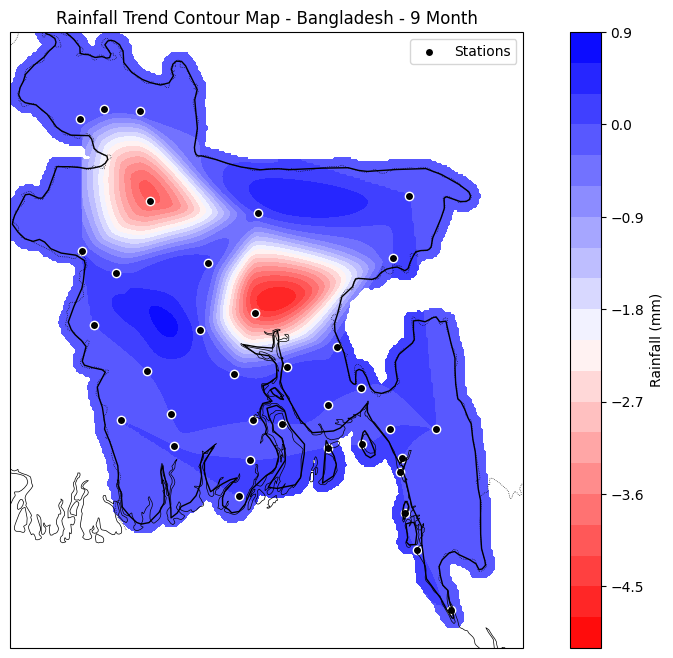

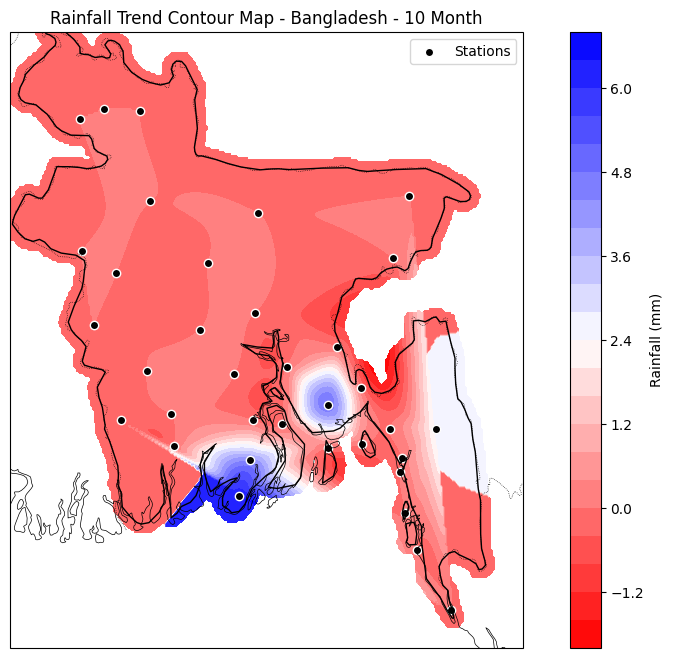

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap

# Assuming the file is in /content/drive/MyDrive/research/
file_path = "/content/drive/MyDrive/research/with LongLat_rainfall_trend_results.csv"

try:
    df = pd.read_csv(file_path)
    print(df.head())  # Print the first few rows to verify
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Convert Latitude and Longitude to Decimal Degrees for easy processing
df['lat_decimal'] = df['Lat (Deg)'] + df['Lat (Min)'] / 60
df['lon_decimal'] = df['Long (Deg)'] + df['Long (Min)'] / 60

# Load Bangladesh boundary from Natural Earth (50m resolution)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
bangladesh_shp = world[world.NAME == "Bangladesh"]

# Create a polygon with a buffer for better edge coverage
bangladesh_polygon = bangladesh_shp.geometry.iloc[0].buffer(0.1)  # Small buffer of 0.1 degrees

# Define grid for interpolation
lon_min, lon_max = 88, 93   # Bangladesh Longitude range
lat_min, lat_max = 20.5, 26.5  # Bangladesh Latitude range
grid_x, grid_y = np.meshgrid(
    np.linspace(lon_min, lon_max, 300),  # Increased resolution
    np.linspace(lat_min, lat_max, 300)
)

# Create a custom colormap for the color scheme (blue for positive, white for zero, red for negative)
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["red", "white", "blue"], N=256)

# Iterate over months (columns 6 to 17)
for month in range(9, 11):
    # Extract rainfall data for this month
    rainfall = df.iloc[:, 6 + month - 1]  # Column 6 corresponds to January, 7 to February, etc.

    # Interpolate using cubic method
    grid_z_cubic = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='cubic')

    # Fill gaps using nearest-neighbor method
    grid_z_nearest = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='nearest')

    # Combine cubic and nearest methods
    grid_z = np.where(np.isnan(grid_z_cubic), grid_z_nearest, grid_z_cubic)

    # Mask values outside Bangladesh
    mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z[~mask.reshape(grid_z.shape)] = np.nan

    # Plot the contour map for each month
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add Bangladesh border
    ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

    # Contour plot with custom colormap
    contour = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap=cmap, transform=ccrs.PlateCarree())

    # Add color bar
    plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

    # Add station points
    ax.scatter(df['lon_decimal'], df['lat_decimal'], c='black', marker='o', edgecolors='white', label="Stations")

    # Add features for better map context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

    # Labels
    ax.set_title(f"Rainfall Trend Contour Map - Bangladesh - {month} Month")
    ax.legend()

    # Save or show the figure
    plt.show()
    # Alternatively, you can save the figure with a specific filename
    # fig.savefig(f"rainfall_map_month_{month}.png")


      Station  Station Number  Lat (Deg)  Lat (Min)  Long (Deg)  Long (Min)  \
0   chuadanga           41926         23         39          88          49   
1     Jessore           41936         23         12          89          20   
2      Khulna           41947         22         47          89          34   
3    Satkhira           41946         22         43          89           5   
4  Chittagong           41977         22         21          91          49   

   1    2    3        4  5  6    7    8    9   10   11  12  
0  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  
1  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  
2  0  0.0  0.0 -1.47619  0  0  0.0  0.0  0.0  0.0  0.0   0  
3  0  0.0  0.0 -2.22581  0  0  0.0  0.0  0.0  0.0  0.0   0  
4  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  


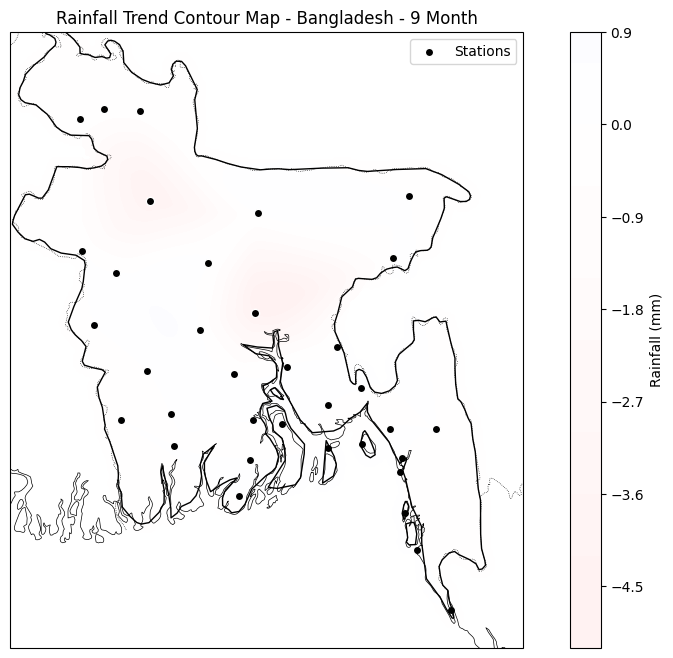

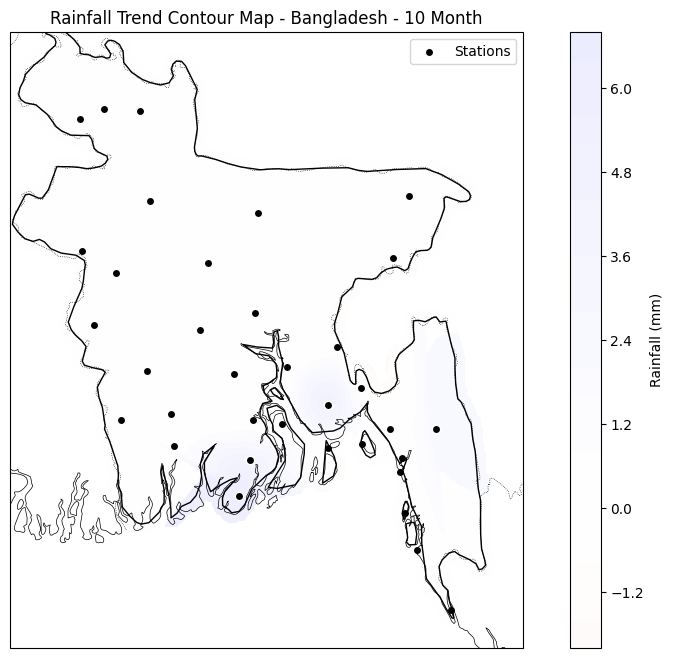

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming the file is in /content/drive/MyDrive/research/
file_path = "/content/drive/MyDrive/research/with LongLat_rainfall_trend_results.csv"

try:
    df = pd.read_csv(file_path)
    print(df.head())  # Print the first few rows to verify
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Convert Latitude and Longitude to Decimal Degrees for easy processing
df['lat_decimal'] = df['Lat (Deg)'] + df['Lat (Min)'] / 60
df['lon_decimal'] = df['Long (Deg)'] + df['Long (Min)'] / 60

# Load Bangladesh boundary from Natural Earth (50m resolution)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
bangladesh_shp = world[world.NAME == "Bangladesh"]

# Create a polygon with a buffer for better edge coverage
bangladesh_polygon = bangladesh_shp.geometry.iloc[0].buffer(0.1)  # Small buffer of 0.1 degrees

# Define grid for interpolation
lon_min, lon_max = 88, 93   # Bangladesh Longitude range
lat_min, lat_max = 20.5, 26.5  # Bangladesh Latitude range
grid_x, grid_y = np.meshgrid(
    np.linspace(lon_min, lon_max, 300),  # Increased resolution
    np.linspace(lat_min, lat_max, 300)
)

# Create a custom colormap where zero is white, negative values are red, and positive values are blue
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["red", "white", "blue"], N=256)

# Normalize with TwoSlopeNorm to ensure zero is white
norm = TwoSlopeNorm(vmin=-np.max(np.abs(df.iloc[:, 6:].values)), vcenter=0, vmax=np.max(np.abs(df.iloc[:, 6:].values)))

# Iterate over months (columns 6 to 17)
for month in range(9, 11):
    # Extract rainfall data for this month
    rainfall = df.iloc[:, 6 + month - 1]  # Column 6 corresponds to January, 7 to February, etc.

    # Interpolate using cubic method
    grid_z_cubic = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='cubic')

    # Fill gaps using nearest-neighbor method
    grid_z_nearest = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='nearest')

    # Combine cubic and nearest methods
    grid_z = np.where(np.isnan(grid_z_cubic), grid_z_nearest, grid_z_cubic)

    # Mask values outside Bangladesh
    mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z[~mask.reshape(grid_z.shape)] = np.nan

    # Plot the contour map for each month
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add Bangladesh border
    ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

    # Contour plot with custom colormap and normalized color map
    contour = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    # Add color bar
    plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

    # Add station points
    ax.scatter(df['lon_decimal'], df['lat_decimal'], c='black', marker='o', edgecolors='white', label="Stations")

    # Add features for better map context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

    # Labels
    ax.set_title(f"Rainfall Trend Contour Map - Bangladesh - {month} Month")
    ax.legend()

    # Save or show the figure
    plt.show()
    # Alternatively, you can save the figure with a specific filename
    # fig.savefig(f"rainfall_map_month_{month}.png")


      Station  Station Number  Lat (Deg)  Lat (Min)  Long (Deg)  Long (Min)  \
0   chuadanga           41926         23         39          88          49   
1     Jessore           41936         23         12          89          20   
2      Khulna           41947         22         47          89          34   
3    Satkhira           41946         22         43          89           5   
4  Chittagong           41977         22         21          91          49   

   1    2    3        4  5  6    7    8    9   10   11  12  
0  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  
1  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  
2  0  0.0  0.0 -1.47619  0  0  0.0  0.0  0.0  0.0  0.0   0  
3  0  0.0  0.0 -2.22581  0  0  0.0  0.0  0.0  0.0  0.0   0  
4  0  0.0  0.0  0.00000  0  0  0.0  0.0  0.0  0.0  0.0   0  


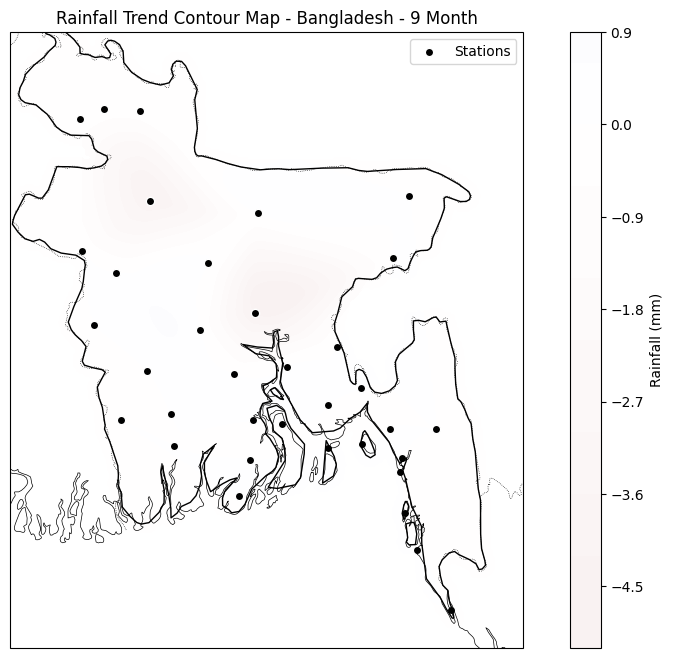

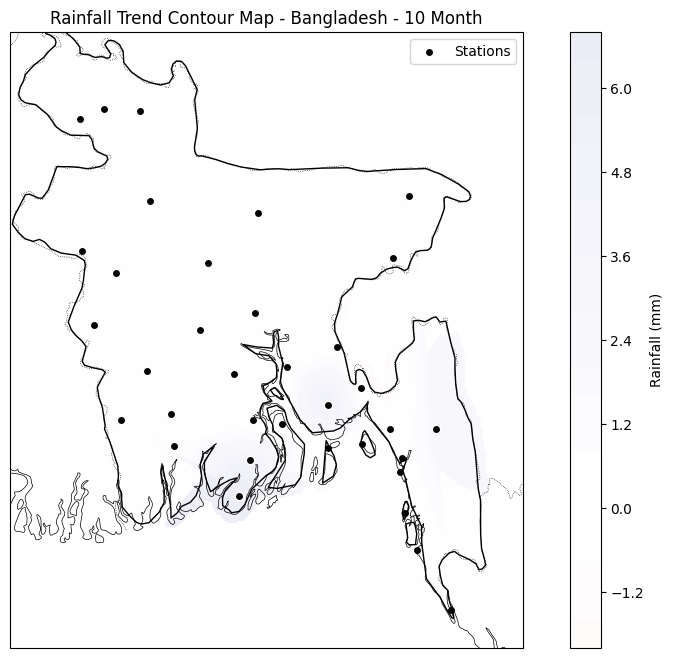

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming the file is in /content/drive/MyDrive/research/
file_path = "/content/drive/MyDrive/research/with LongLat_rainfall_trend_results.csv"

try:
    df = pd.read_csv(file_path)
    print(df.head())  # Print the first few rows to verify
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Convert Latitude and Longitude to Decimal Degrees for easy processing
df['lat_decimal'] = df['Lat (Deg)'] + df['Lat (Min)'] / 60
df['lon_decimal'] = df['Long (Deg)'] + df['Long (Min)'] / 60

# Load Bangladesh boundary from Natural Earth (50m resolution)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
bangladesh_shp = world[world.NAME == "Bangladesh"]

# Create a polygon with a buffer for better edge coverage
bangladesh_polygon = bangladesh_shp.geometry.iloc[0].buffer(0.1)  # Small buffer of 0.1 degrees

# Define grid for interpolation
lon_min, lon_max = 88, 93   # Bangladesh Longitude range
lat_min, lat_max = 20.5, 26.5  # Bangladesh Latitude range
grid_x, grid_y = np.meshgrid(
    np.linspace(lon_min, lon_max, 300),  # Increased resolution
    np.linspace(lat_min, lat_max, 300)
)

# Create a custom colormap where zero is white, negative values are red, and positive values are blue
# Using more distinct red and blue shades
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["darkred", "white", "darkblue"], N=256)

# Normalize with TwoSlopeNorm to ensure zero is white and apply equal color scaling across all months
max_value = np.max(np.abs(df.iloc[:, 6:].values))  # Find the maximum absolute rainfall value for normalization
norm = TwoSlopeNorm(vmin=-max_value, vcenter=0, vmax=max_value)

# Iterate over months (columns 6 to 17)
for month in range(9, 11):
    # Extract rainfall data for this month
    rainfall = df.iloc[:, 6 + month - 1]  # Column 6 corresponds to January, 7 to February, etc.

    # Interpolate using cubic method
    grid_z_cubic = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='cubic')

    # Fill gaps using nearest-neighbor method
    grid_z_nearest = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='nearest')

    # Combine cubic and nearest methods
    grid_z = np.where(np.isnan(grid_z_cubic), grid_z_nearest, grid_z_cubic)

    # Mask values outside Bangladesh
    mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z[~mask.reshape(grid_z.shape)] = np.nan

    # Plot the contour map for each month
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add Bangladesh border
    ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

    # Contour plot with custom colormap and normalized color map
    contour = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    # Add color bar
    plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

    # Add station points
    ax.scatter(df['lon_decimal'], df['lat_decimal'], c='black', marker='o', edgecolors='white', label="Stations")

    # Add features for better map context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

    # Labels
    ax.set_title(f"Rainfall Trend Contour Map - Bangladesh - {month} Month")
    ax.legend()

    # Save or show the figure
    plt.show()
    # Alternatively, you can save the figure with a specific filename
    # fig.savefig(f"rainfall_map_month_{month}.png")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# Assuming the file is in /content/drive/MyDrive/research/
file_path = "/content/drive/MyDrive/research/with LongLat_rainfall_trend_results.csv"

try:
    df = pd.read_csv(file_path)
    print(df.head())  # Print the first few rows to verify
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Convert Latitude and Longitude to Decimal Degrees for easy processing
df['lat_decimal'] = df['Lat (Deg)'] + df['Lat (Min)'] / 60
df['lon_decimal'] = df['Long (Deg)'] + df['Long (Min)'] / 60

# Load Bangladesh boundary from Natural Earth (50m resolution)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
bangladesh_shp = world[world.NAME == "Bangladesh"]

# Create a polygon with a buffer for better edge coverage
bangladesh_polygon = bangladesh_shp.geometry.iloc[0].buffer(0.1)  # Small buffer of 0.1 degrees

# Define grid for interpolation
lon_min, lon_max = 88, 93   # Bangladesh Longitude range
lat_min, lat_max = 20.5, 26.5  # Bangladesh Latitude range
grid_x, grid_y = np.meshgrid(
    np.linspace(lon_min, lon_max, 300),  # Increased resolution
    np.linspace(lat_min, lat_max, 300)
)

# Create a custom colormap with darker red and blue shades
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["darkred", "white", "darkblue"], N=256)

# Apply a custom stretching to the colormap to make color differences more pronounced
max_value = np.max(np.abs(df.iloc[:, 6:].values))  # Find the maximum absolute rainfall value for normalization
min_value = np.min(df.iloc[:, 6:].values)  # Find the minimum rainfall value
norm = TwoSlopeNorm(vmin=-max_value, vcenter=0, vmax=max_value)  # Symmetric normalization

# Iterate over months (columns 6 to 17)
for month in range(9, 11):
    # Extract rainfall data for this month
    rainfall = df.iloc[:, 6 + month - 1]  # Column 6 corresponds to January, 7 to February, etc.

    # Interpolate using cubic method
    grid_z_cubic = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='cubic')

    # Fill gaps using nearest-neighbor method
    grid_z_nearest = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='nearest')

    # Combine cubic and nearest methods
    grid_z = np.where(np.isnan(grid_z_cubic), grid_z_nearest, grid_z_cubic)

    # Mask values outside Bangladesh
    mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z[~mask.reshape(grid_z.shape)] = np.nan

    # Plot the contour map for each month
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add Bangladesh border
    ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

    # Contour plot with custom colormap and normalized color map
    contour = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    # Add color bar
    plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

    # Add station points
    ax.scatter(df['lon_decimal'], df['lat_decimal'], c='black', marker='o', edgecolors='white', label="Stations")

    # Add features for better map context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

    # Labels
    ax.set_title(f"Rainfall Trend Contour Map - Bangladesh - {month} Month")
    ax.legend()

    # Save or show the figure
    plt.show()
    # Alternatively, you can save the figure with a specific filename
    # fig.savefig(f"rainfall_map_month_{month}.png")


**Last Good**

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
from scipy.interpolate import Rbf

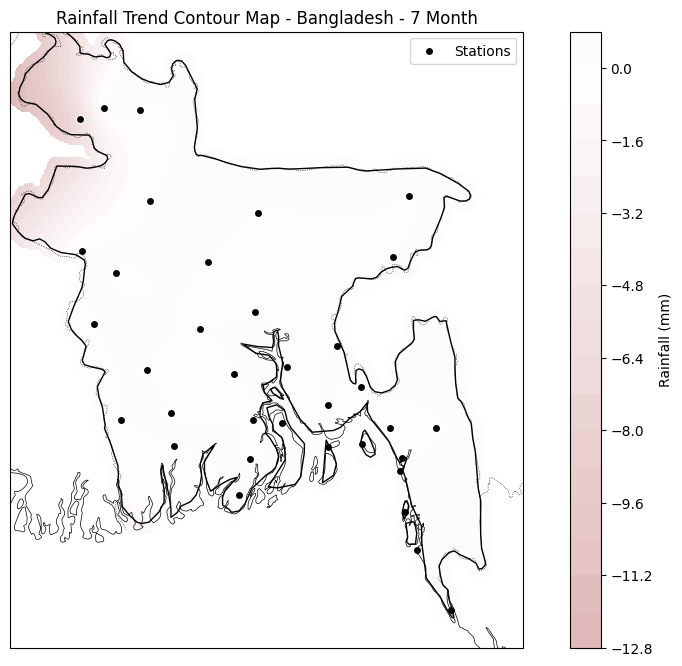

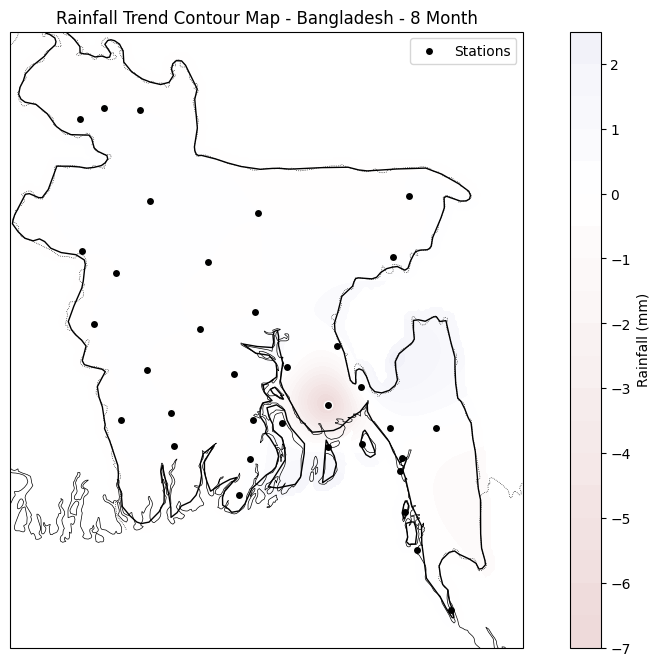

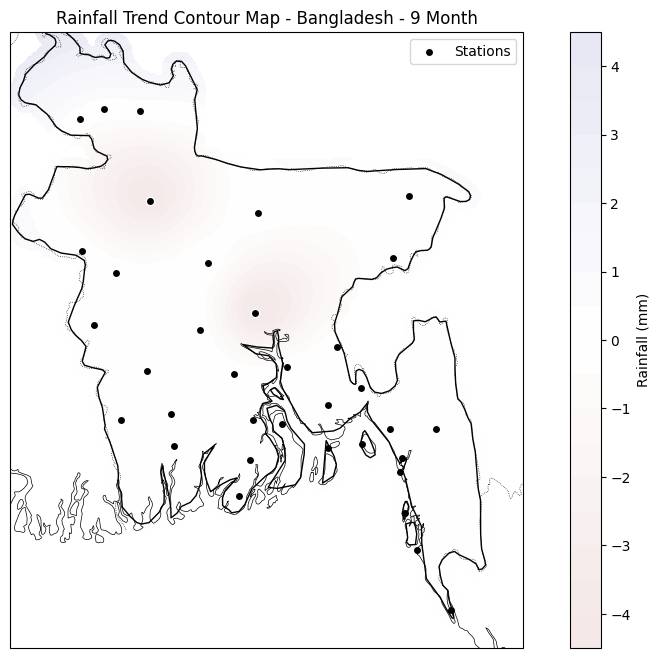

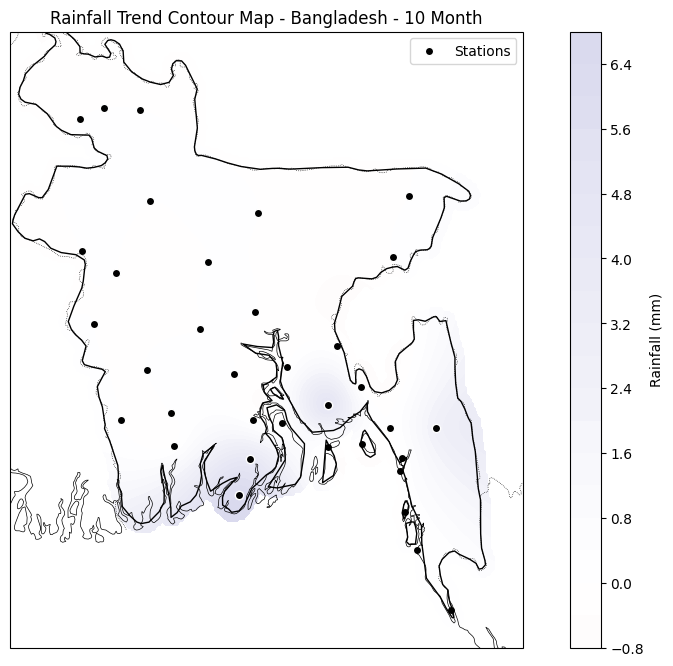

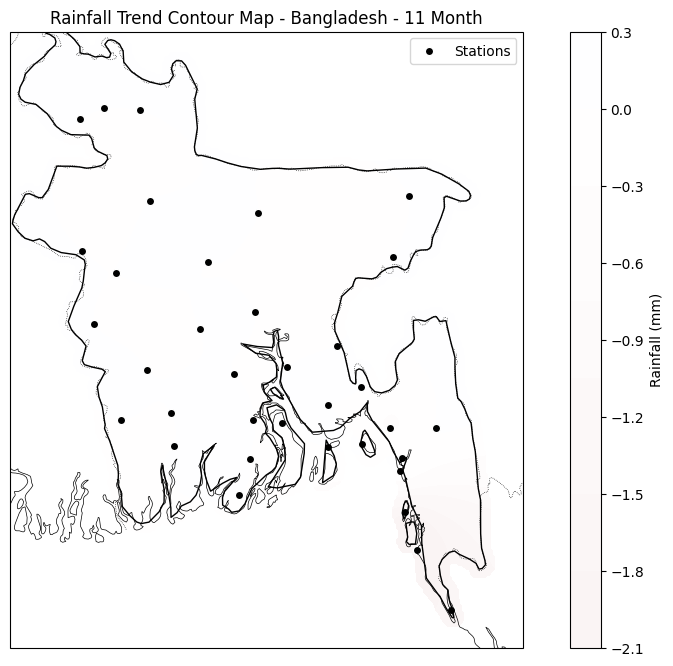

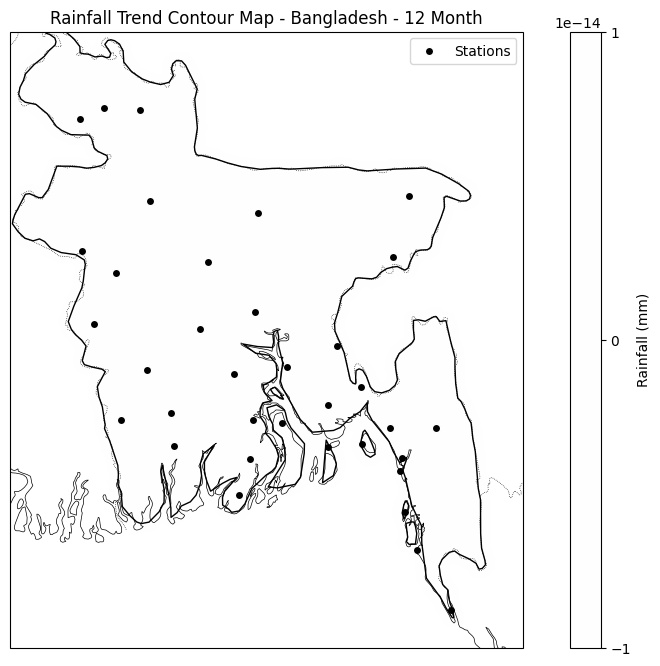

In [16]:

# Assuming the file is in /content/drive/MyDrive/research/
file_path = "/content/drive/MyDrive/research/with LongLat_rainfall_trend_results.csv"

try:
    df = pd.read_csv(file_path)
    #print(df.head())  # Print the first few rows to verify
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except Exception as e:
    print(f"An error occurred: {e}")

# Convert Latitude and Longitude to Decimal Degrees for easy processing
df['lat_decimal'] = df['Lat (Deg)'] + df['Lat (Min)'] / 60
df['lon_decimal'] = df['Long (Deg)'] + df['Long (Min)'] / 60

# Load Bangladesh boundary from Natural Earth (50m resolution)
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip")
bangladesh_shp = world[world.NAME == "Bangladesh"]

# Create a polygon with a buffer for better edge coverage
bangladesh_polygon = bangladesh_shp.geometry.iloc[0].buffer(0.1)  # Small buffer of 0.1 degrees

# Define grid for interpolation
lon_min, lon_max = 88, 93   # Bangladesh Longitude range
lat_min, lat_max = 20.5, 26.5  # Bangladesh Latitude range

resulation = 300;
grid_x, grid_y = np.meshgrid(
    np.linspace(lon_min, lon_max, resulation),  # Increased resolution
    np.linspace(lat_min, lat_max, resulation)
)

# Create a custom colormap with darker red and blue shades
cmap = LinearSegmentedColormap.from_list("custom_cmap", ["darkred", "white", "darkblue"], N=256)

# Define a color intensity variable (you can adjust this value as needed)
color_intensity = 0.5 # Adjust this value to control color intensity: 1.0 = standard, >1.0 = more intense colors

# Normalize the data with scaling for color intensity control
max_value = np.max(np.abs(df.iloc[:, 6:].values))  # Find the maximum absolute rainfall value for normalization
norm = TwoSlopeNorm(vmin=-max_value * color_intensity, vcenter=0, vmax=max_value * color_intensity)  # Scale based on color_intensity

# Iterate over months (columns 6 to 17)
for month in range(7, 13):
    # Extract rainfall data for this month
    rainfall = df.iloc[:, 6 + month - 1]  # Column 6 corresponds to January, 7 to February, etc.
    #print(rainfall)

    grid_z_linear = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='linear')

    rbf = Rbf(df['lon_decimal'], df['lat_decimal'], rainfall, function='thin_plate')
    grid_z_spline = rbf(grid_x, grid_y)
    # Interpolate using cubic method
    grid_z_cubic = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='cubic')

    # Fill gaps using nearest-neighbor method
    grid_z_nearest = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='nearest')

    grid_z_method = grid_z_spline
    # Combine cubic and nearest methods
    grid_z = np.where(np.isnan(grid_z_method), grid_z_method, grid_z_method)

    # Mask values outside Bangladesh
    mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z[~mask.reshape(grid_z.shape)] = np.nan


    # Plot the contour map for each month
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add Bangladesh border
    ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

    # Contour plot with custom colormap and normalized color map
    contour = ax.contourf(grid_x, grid_y, grid_z, levels=20, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    # Add color bar
    plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

    # Add station points
    ax.scatter(df['lon_decimal'], df['lat_decimal'], c='black', marker='o', edgecolors='white', label="Stations")

    # Add features for better map context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

    # Labels
    ax.set_title(f"Rainfall Trend Contour Map - Bangladesh - {month} Month")
    ax.legend()

    # Save or show the figure
    plt.show()
    # Alternatively, you can save the figure with a specific filename
    # fig.savefig(f"rainfall_map_month_{month}.png")


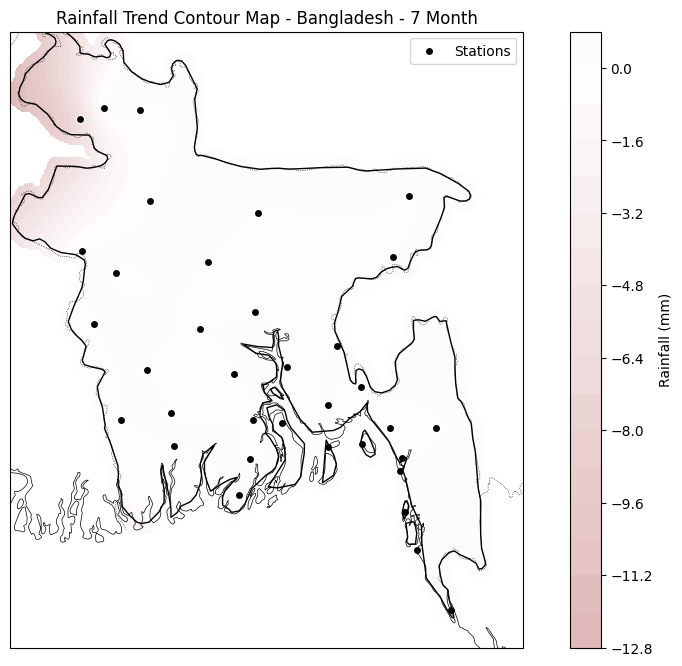

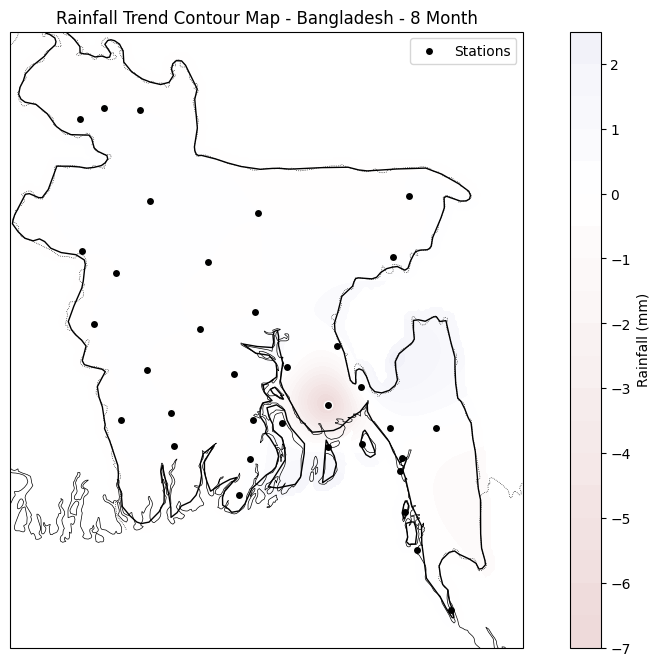

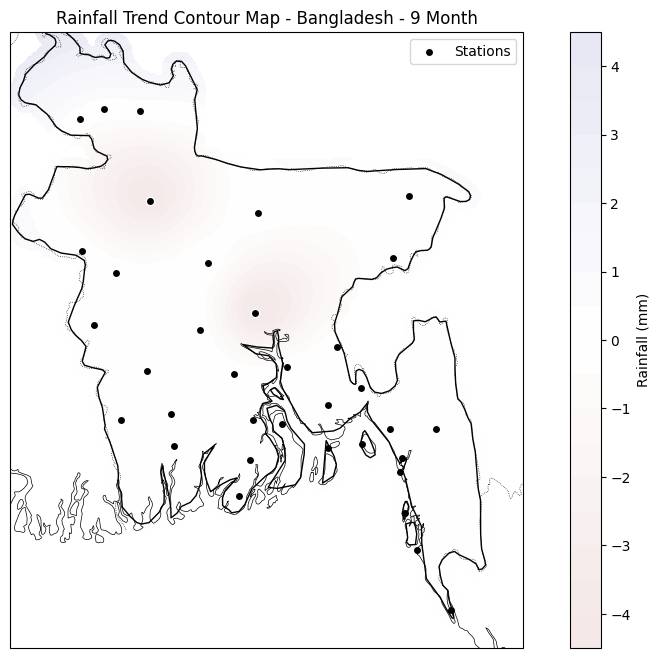

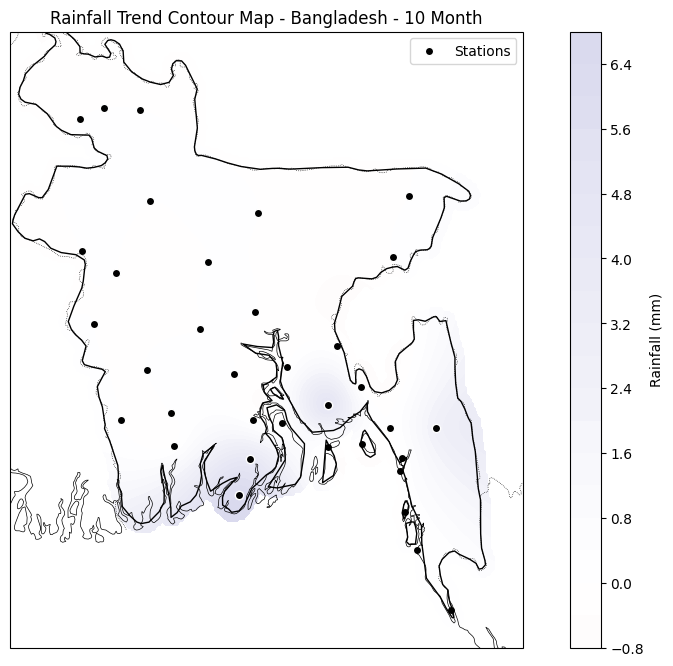

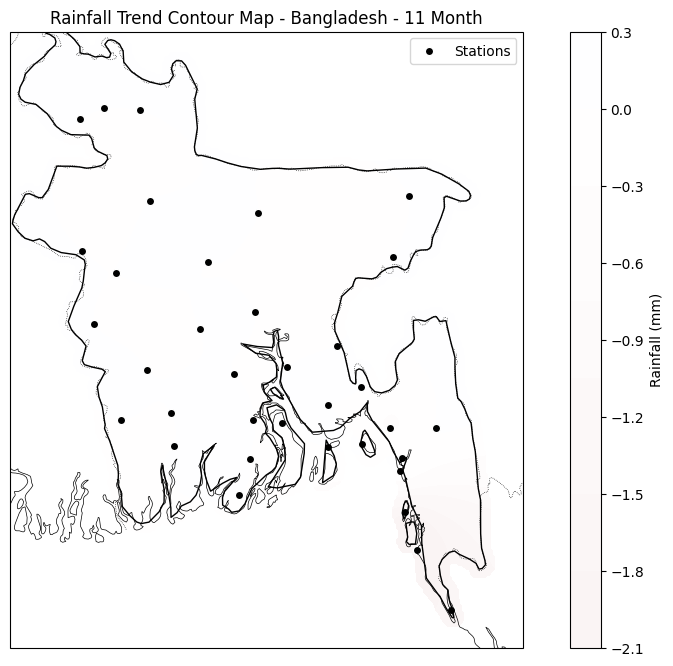

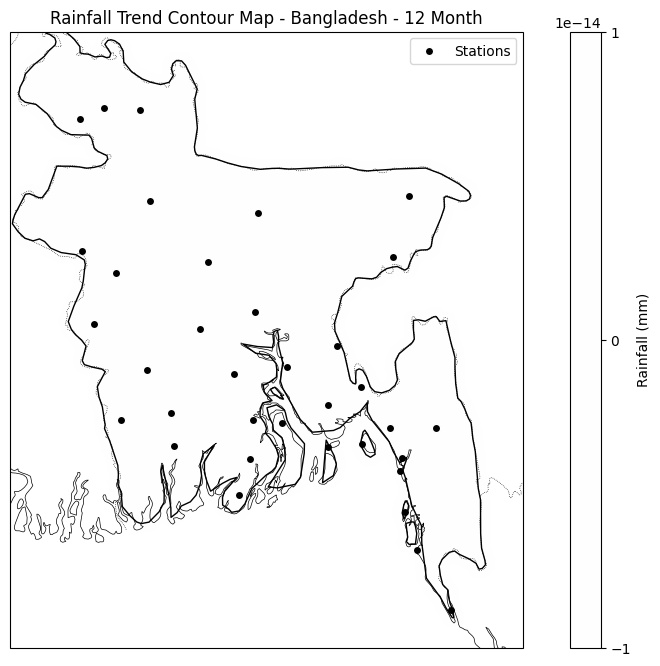

In [20]:
# Replace the values outside the boundary with the nearest station value
def replace_extrapolated_with_last_station(grid_z, grid_x, grid_y, df, bangladesh_polygon):
    # Get the indices of points that are outside the Bangladesh boundary
    mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])

    # Get the coordinates of stations inside the boundary
    valid_stations_lon = df['lon_decimal']
    valid_stations_lat = df['lat_decimal']
    valid_stations_rainfall = df.iloc[:, 6 + month - 1]

    # Identify the stations close to the boundary by checking the lat/lon range
    # We can simply look for the stations close to the boundary (within a certain distance)
    boundary_stations_mask = (
        (valid_stations_lon < lon_min + 0.5) | (valid_stations_lon > lon_max - 0.5) |
        (valid_stations_lat < lat_min + 0.5) | (valid_stations_lat > lat_max - 0.5)
    )

    boundary_stations_lon = valid_stations_lon[boundary_stations_mask]
    boundary_stations_lat = valid_stations_lat[boundary_stations_mask]
    boundary_stations_rainfall = valid_stations_rainfall[boundary_stations_mask]

    # Iterate over the points outside the boundary and replace with the nearest station value
    for idx in np.where(~mask)[0]:  # Outside the boundary
        lon, lat = grid_x.flatten()[idx], grid_y.flatten()[idx]

        # Find the closest boundary station
        distances = np.sqrt((boundary_stations_lon - lon)**2 + (boundary_stations_lat - lat)**2)
        closest_station_idx = np.argmin(distances)  # Find the closest boundary station
        grid_z.flatten()[idx] = boundary_stations_rainfall.iloc[closest_station_idx]  # Assign the nearest value

    return grid_z

# Iterate over months (columns 6 to 17)
for month in range(7, 13):
    # Extract rainfall data for this month
    rainfall = df.iloc[:, 6 + month - 1]  # Column 6 corresponds to January, 7 to February, etc.

    # Interpolation using different methods
    grid_z_linear = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='linear')
    rbf = Rbf(df['lon_decimal'], df['lat_decimal'], rainfall, function='thin_plate')
    grid_z_spline = rbf(grid_x, grid_y)
    grid_z_cubic = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='cubic')
    grid_z_nearest = griddata((df['lon_decimal'], df['lat_decimal']), rainfall, (grid_x, grid_y), method='nearest')

    grid_z_method = grid_z_spline

    # Replace extrapolated values outside the boundary with the last station value
    grid_z_corrected = replace_extrapolated_with_last_station(grid_z_method, grid_x, grid_y, df, bangladesh_polygon)

    # Mask the values outside Bangladesh (optional step for completeness)
    mask = np.array([Point(lon, lat).within(bangladesh_polygon) for lon, lat in zip(grid_x.flatten(), grid_y.flatten())])
    grid_z_corrected[~mask.reshape(grid_z_corrected.shape)] = np.nan

    # Plot the contour map for each month
    fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.set_extent([lon_min, lon_max, lat_min, lat_max])

    # Add Bangladesh border
    ax.add_geometries(bangladesh_shp.geometry, ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1)

    # Contour plot with custom colormap and normalized color map
    contour = ax.contourf(grid_x, grid_y, grid_z_corrected, levels=20, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())

    # Add color bar
    plt.colorbar(contour, ax=ax, orientation='vertical', label="Rainfall (mm)")

    # Add station points
    ax.scatter(df['lon_decimal'], df['lat_decimal'], c='black', marker='o', edgecolors='white', label="Stations")

    # Add features for better map context
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linewidth=0.5, linestyle='dotted')

    # Labels
    ax.set_title(f"Rainfall Trend Contour Map - Bangladesh - {month} Month")
    ax.legend()

    # Save or show the figure
    plt.show()
    # Alternatively, you can save the figure with a specific filename
    # fig.savefig(f"rainfall_map_month_{month}.png")
